# Figures

In [1]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [21]:
N = 100
nreps = 1003
suf = "di" #"di"

run_dir = f"{results_dir}run_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
file_name = f"{run_dir}thetas_arr_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.npy"

data = np.load(file_name) # end states

file_name = f"{run_dir}df_long_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"

df = pd.read_csv(file_name, index_col=0)


## Basin size

In [22]:
mask_pos = df["state"].str.startswith('-')  # Create a mask for rows where "state" starts with "-"
mask_sync = df["state"] != "sync"
mask = ~mask_pos * mask_sync
masked_df = df[mask]

In [23]:
masked_df.state.unique()

array(['0-twisted', '1-twisted', '2-twisted', '3-twisted', '4-twisted',
       '5-twisted', 'other'], dtype=object)

In [24]:
[i for i in masked_df.state.unique() if "twisted" in i]

['0-twisted', '1-twisted', '2-twisted', '3-twisted', '4-twisted', '5-twisted']

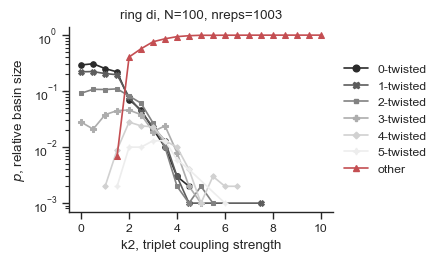

In [25]:
#labels = [f"{i}-twisted" for i in range(5)] + ["other"]
labels = [i for i in masked_df.state.unique() if "twisted" in i] + ["other"]

fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df[mask],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    #alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    #mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(labels)-1) + ["r"]
)

g.set(yscale="log")
sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")

ax.set_xlabel("k2, triplet coupling strength")
ax.set_ylabel("$p$, relative basin size")

title = f"ring {suf}, N={N}, nreps={nreps}"
ax.set_title(title)

sb.despine()
#ax.set_ylim(ymax=1.1)

fig_name = f"basin_size_ring_{suf}_N_{N}_nreps_{nreps}"

#plt.savefig(f"{run_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_34974/2684334774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twisted["q"] = df_twisted["state"].str[:-8].astype(int)


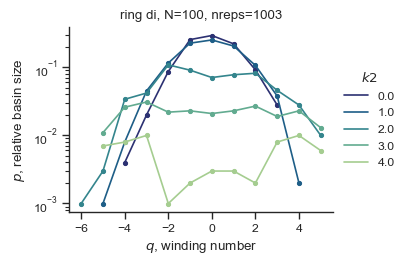

In [26]:
mask_k2 = df["k2"].isin(np.arange(0, 4))
mask_other = df["state"] != "other"

mask_twisted = df["state"].str.contains("twisted")
df_twisted = df[mask_twisted]
df_twisted["q"] = df_twisted["state"].str[:-8].astype(int)
mask_k2 = df_twisted["k2"].isin(np.arange(0, 5))


fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df_twisted[mask_k2],
    hue="k2",
    y="proba",
    x="q",
    marker="o",
    ms=3,
    #mfc="w",
    mec=None,
    ax=ax,
    #alpha=0.7,
    #style="k2",
    dashes=False,
    #hue_order=[0, 1, 2, 3, 4],
    legend="full",
    palette="crest_r"
)

g.set(yscale="log")
sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="$k2$")


sb.despine()

#plt.xticks(rotation=45)
ax.set_xlabel("$q$, winding number")
ax.set_ylabel("$p$, relative basin size")

title = f"ring {suf}, N={N}, nreps={nreps}"
ax.set_title(title)

sb.despine()
#ax.set_ylim(ymax=1.1)

fig_name = f"basin_size_ring_{suf}_N_{N}_nreps_{nreps}_b"

#plt.savefig(f"{run_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

plt.show()

## Local order parameter

In [27]:
from numba import jit 

r2 = 2

@jit 
def compute_local_order(phases, r2):
    
    n_k2, nreps, N = phases.shape
    
    local_order = np.zeros((n_k2, nreps, N), dtype=np.complex64)

    for ll in range(n_k2):
        for kk in range(nreps):
            psi = phases[ll, kk]

            for ii in range(N):
                for j in range(-r2, r2+1):
                    idx = (ii + j) % N
                    local_order[ll, kk, ii] += np.exp(1j * psi[idx])
                    
    local_order /= (2 * r2 + 1)
    local_order = np.abs(local_order)
                    
    return local_order

In [28]:
local_order = compute_local_order(data, r2)

In [29]:
threshold = 0.85

local_order_bool = local_order.copy()

local_order_bool[local_order < threshold] = 0
local_order_bool[local_order >= threshold] = 1

mean_order = np.mean(local_order_bool, axis=-1)

In [31]:
k2s

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        8. ,  5.5,  7.5,  6.5,  7. ,  6. ,  8.5,  9. ,  9.5, 10. ])

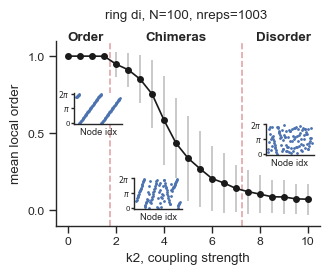

In [108]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))

k2s = sorted(df["k2"].unique())
y_mean = np.mean(mean_order, axis=1)
y_std = np.std(mean_order, axis=1)

ax.errorbar(
    k2s, y_mean, yerr=y_std, marker="o", ms=4, color="k", ecolor="silver", mfc="k"
)

sb.despine()

ax.set_ylim([-0.1, 1.1])
ax.set_yticks([0, 0.5, 1])

ax.set_xlabel("k2, coupling strength")
ax.set_ylabel("mean local order")

# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins1 = inset_axes(
    ax,
    width="100%", height="100%",
    bbox_to_anchor=(0.5, 0.6, 2, 0.2),
    bbox_transform=ax.transData,
)

plot_phases_line(data[5, 6, :, None], it=-1, ax=axins1, c="b", ms=1)

axins1.set_ylabel("")
plt.yticks(fontsize="xx-small")
axins1.set_xticks([])
#plt.yticks(fontsize="x-small")
axins1.set_xlabel("Node idx", fontsize="x-small", labelpad=3)


axins2 = inset_axes(
    ax,
    width="100%", height="100%",
    bbox_to_anchor=(3, 0.05, 2, 0.2),
    bbox_transform=ax.transData,
)

plot_phases_line(data[8, 14, :, None], it=-1, ax=axins2, c="b", ms=1)

axins2.set_ylabel("")
plt.yticks(fontsize="xx-small")
axins2.set_xticks([])
#plt.yticks(fontsize="x-small")
axins2.set_xlabel("Node idx", fontsize="x-small", labelpad=3)


axins3 = inset_axes(
    ax,
    width="100%", height="100%",
    bbox_to_anchor=(8.5, 0.4, 2, 0.2),
    bbox_transform=ax.transData,
)

plot_phases_line(data[17, 14, :, None], it=-1, ax=axins3, c="b", ms=1)

axins3.set_ylabel("")
plt.yticks(fontsize="xx-small")
axins3.set_xticks([])
#plt.yticks(fontsize="x-small")
axins3.set_xlabel("Node idx", fontsize="x-small", labelpad=3)

ax.axvline(1.75, c="r", ls="--", alpha=0.5)
ax.axvline(7.25, c="r", ls="--", alpha=0.5)

ax.text(0.7, 1.1, "Order", ha="center", weight="bold")
ax.text(4.5, 1.1, "Chimeras", ha="center", weight="bold")
ax.text(9, 1.1, "Disorder", ha="center", weight="bold")

#plt.subplots_adjust(top=0.99)
title = f"ring {suf}, N={N}, nreps={nreps} \n"
ax.set_title(title)

axins1.tick_params('both', length=2, which='major', pad=1)
axins2.tick_params('both', length=2, which='major', pad=1)
axins3.tick_params('both', length=2, which='major', pad=1)
#axins1.tick_params('both', length=10, width=1, which='minor')


fig_name = f"local_order_ring_{suf}_N_{N}_nreps_{nreps}"

# plt.savefig(f"{run_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

plt.show()

<Axes: xlabel='Node index', ylabel='Phase'>

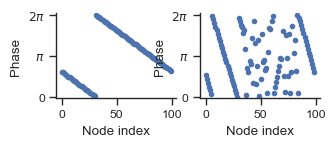

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.4, 1.1), sharey=False)

plot_phases_line(data[5, 6, :, None], it=-1, ax=ax1, c="b", ms=3)

plot_phases_line(data[15, 12, :, None], it=-1, ax=ax2, c="b", ms=3)

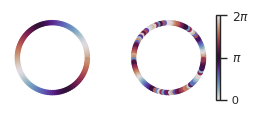

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 1.1))

H = xgi.trivial_hypergraph(N)

_, im1 = plot_phases_ring(H, thetas=data[5, 6, :, None], it=-1, ax=ax1, node_size=4, colorbar=False)

_, im2 = plot_phases_ring(H, thetas=data[15, 12, :, None], it=-1, ax=ax2, node_size=4, colorbar=True)

In [ ]:
plot_phases